In [ ]:
import re
import time

# Read data

In [ ]:
#Temp cell to get no. of lines of each dataset for preliminary analysis

with open('wiki.train.dot', "r") as f:
  texts_train = f.read()
with open('wiki.valid.dot', "r") as f:
  texts_valid_dot = f.read()
with open('wiki.valid.txt', "r") as f:
  texts_valid_txt = f.read() 
with open('wiki.test.dot', "r") as f:
  texts_test_dot = f.read()
with open('wiki.test.txt', "r") as f:
  texts_test_txt = f.read()

print('# of lines in train dot file', len(texts_train))
print('# of lines in valid dot file', len(texts_valid_dot))
print('# of lines in valid txt file', len(texts_valid_txt))
print('# of lines in test dot file', len(texts_test_dot))
print('# of lines in test txt file', len(texts_test_txt))


# of lines in train dot file 10780437
# of lines in valid dot file 1120192
# of lines in valid txt file 1120192
# of lines in test dot file 1255018
# of lines in test txt file 1255018


In [ ]:
lines_dot = []
lines_txt = []
corrupted_words = []
corrupted_labels = []    # the true label of the corrupted words

with open('wiki.train.dot', "r") as f:
  texts_train = f.read()
with open('wiki.test.dot', "r") as f:
  texts_dot = f.read()
with open('wiki.test.txt', "r") as f:
  texts_txt = f.read()

print('# of lines in dot file', len(texts_dot))
print('# of lines in txt file', len(texts_txt))


# print('# of words in dot:', len(texts_dot.split(' ')))
# print('# of words in txt:', len(texts_txt.split(' ')))

raw_words_dot= texts_dot.split(' ')
raw_words_txt= texts_txt.split(' ')

for i, word in enumerate(raw_words_dot):
    if chr(183) in word:
        corrupted_words.append(word)
        corrupted_labels.append(raw_words_txt[i])

print('examples of corrupted words:', corrupted_words[-10:])
print('examples of their labels:', corrupted_labels[-10:])

# of lines in dot file 1255018
# of lines in txt file 1255018
examples of corrupted words: ['·inal', 'be·ng', '<unk·', 'he·o', 'becaus·', '·unk>', 'direc·ion', 'relea·e', 'furth·r', 'r·al']
examples of their labels: ['final', 'being', '<unk>', 'hero', 'because', '<unk>', 'direction', 'release', 'further', 'real']


# **Pre-processing**

In [ ]:
import string
def extractTokens(texts):
    tokens = []
    # -- Remove punctuation and new lines
    texts = re.sub(r'[^\w\s\·]', '', texts)
    texts = re.sub(r'[\n]', ' ', texts)
    # -- Split into words by space
    words = texts.split(' ')
    # -- Remove words shorter than 2 charaters
    # for word in words:
    #     if len(word) < 2 :
    #         words.remove(word)
    # print('# of words after remove:', len(words))

    # -- Remove stop words ('unk' and 'usp')
    # -- Remove capitalization
    stop_words = ['unk', '·nk', 'u·k', 'un·', '·unk', 'unk·', '']
    tokens += [x.lower() for x in words if x not in stop_words]
    # if i == 3300: print('len of words at line', i, ':', len(words))
    # for word in words:
    #     if chr(183) in word:
    #         print(word)

    return tokens

In [ ]:
tokens_dot = extractTokens(texts_dot)
tokens_txt = extractTokens(texts_txt)
print('# of words in dot file:', len(tokens_dot))
print('# of words in dot file:', len(tokens_txt))
print('examples of processed words in dot file:', tokens_dot[9:20])

# of words in dot file: 191126
# of words in dot file: 191126
examples of processed words in dot file: ['actor', 'he', 'had', 'a', 'guest', 'starring', 'role', 'on', 'the', 'television', 'series']


## Extract corrupted words and their uncorrupted version

In [ ]:
corrupted_tokens_dot = []
uncorrupted_tokens_dot = []
label_tokens_txt = []

for i, token in enumerate(tokens_dot):
    if chr(183) in token:
        corrupted_tokens_dot.append(token)
        label_tokens_txt.append(tokens_txt[i])
    else:
        uncorrupted_tokens_dot.append(token)
print('len of corrupted:', len(corrupted_tokens_dot))
print('len of uncorrupted:', len(uncorrupted_tokens_dot))
print(corrupted_tokens_dot[-10:])
print(label_tokens_txt[-10:])

len of corrupted: 1154
len of uncorrupted: 189972
['som·thing', 'sar·h', '·inal', 'be·ng', 'he·o', 'becaus·', 'direc·ion', 'relea·e', 'furth·r', 'r·al']
['something', 'sarah', 'final', 'being', 'hero', 'because', 'direction', 'release', 'further', 'real']


In [ ]:
chr(183)

'·'

## **BASIC NAIVE BAYES**

In [ ]:
def basic_nb (curr, train_data):
    # curr = corrupted_tokens_dot[0]
    split = curr.split('·')
    # -- If the black dot is at front or end
    if len(split) == 1:
        if curr[0] == '·':
            pattern = '[^\w][\w]{}[^\w]'.format(split)
        elif curr[-1] == '·':
            pattern = '[^\w]{}[\w][^\w]'.format(split)
    # -- If the black dot is in the middle
    elif len(split) == 2:
        pattern = '[^\w]{0}[\w]{1}[^\w]'.format(split[0], split[1])

    matches = re.findall(pattern, train_data)
    trims = []
    for match in matches:
        trims.append(re.sub(r'[^\w]', '', match))
    # print('corrupted word:', curr)
    # print('found matches:', trims)
    uniques = list(set(trims))
    pred = ''
    max_count = float('-inf')
    for unique in uniques:
        if trims.count(unique) > max_count:
            pred = unique
            max_count = trims.count(unique)
    
    return pred

## Test

In [ ]:
start = time.time()
correct_pred = 0.0
no_match = 0.0
for i, token in enumerate(corrupted_tokens_dot):
    pred = basic_nb(token, texts_train)
    if pred == label_tokens_txt[i]:
        correct_pred += 1
    if pred == '':
        no_match += 1
acc = correct_pred/len(corrupted_tokens_dot)
end = time.time()
print('accuracy: {:.2f}%'.format(acc*100))
print('time elapsed: {}s'.format(end - start))
print('ratio of no match:', no_match/len(corrupted_tokens_dot))

accuracy: 84.32%
time elapsed: 338.3108642101288s
ratio of no match: 0.07712305025996534


In [ ]:
# -- Just try random stuff
match = re.findall('[a-z]?sa', 'usa asa bsa')
if match:
    print(match)

split = ' abc'.split()
print('[^\w][\w]{0}{1}[^\w]'.format('a', 'b'))

['usa', 'asa', 'bsa']
[^\w][\w]ab[^\w]


## **JAMPSELL (improved Norvig)**

Package: https://github.com/bakwc/JamSpell#python

Install in CoLab: https://colab.research.google.com/drive/1aFk8-7nq3oAp402jjLGLpEb2Nzq210Eo#scrollTo=WQpKf25MYFtA

In [ ]:
# !ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"

In [ ]:
# !brew install swig3
# !pip install jamspell

In [ ]:
!sudo apt-get install swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (768 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (T

In [ ]:
!sudo pip install jamspell

     |████████████████████████████████| 174 kB 8.5 MB/s 
  Created wheel for jamspell: filename=jamspell-0.0.12-cp37-cp37m-linux_x86_64.whl size=1347634 sha256=fadc396d0d00ed8b3574302c28265edbe92037bfe9648b32fe85c12025d1e510
  Stored in directory: /root/.cache/pip/wheels/68/df/9c/9b335e69aa0f28e7f508ec0ebefadcc703f168beb52ae7ebe7
Successfully built jamspell


## Train language model

In [ ]:
!apt-get install cmake

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!git clone https://github.com/bakwc/JamSpell.git
!mkdir /content/JamSpell/build
!cmake /content/JamSpell
!make

In [ ]:
# !./main/jamspell train alphabet_en.txt wiki.valid.txt model_validset.bin

## Use pre-trained model

In [ ]:
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvf en.tar.gz

--2021-11-30 23:27:32--  https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz [following]
--2021-11-30 23:27:33--  https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36611828 (35M) [application/octet-stream]
Saving to: ‘en.tar.gz’

en.tar.gz           100%[===================>]  34.92M   182MB/s    in 0.2s    

2021-11-30 23:27:34 (182 MB/s) - ‘en.tar.gz’ saved [36611828/36611828]

en.bin


## Evaluate

In [ ]:
# !python ./JamSpell/evaluate/evaluate.py -a alphabet_en.txt -jsp model_validset.bin -mx 50000 wiki.test.dot

**Do restart Colab**

In [ ]:
import jamspell
from importlib import reload
reload(jamspell)
corrector = jamspell.TSpellCorrector()
# corrector.LoadLangModel('model_validset.bin')
corrector.LoadLangModel('en.bin')
assert corrector.LoadLangModel('en.bin')

In [ ]:
# corrector.FixFragment('I am the begt spell cherken!')
# u'I am the best spell checker!'

# corrector.GetCandidates(['i', 'am', 'the', 'begt', 'spell', 'cherken'], 3)
# # (u'best', u'beat', u'belt', u'bet', u'bent', ... )

# corrector.GetCandidates(['i', 'am', 'the', 'begt', 'spell', 'cherken'], 5)
# # (u'checker', u'chicken', u'checked', u'wherein', u'coherent', ...)

In [ ]:
# -- Replace black dot with letter 'q' to adjust for model
tokens_dot_adj = []
for token in tokens_dot:
    if re.search('·', token):
        tokens_dot_adj.append(re.sub(r'·', 'q', token))
    else:
        tokens_dot_adj.append(token)
# -- Join the processed list of words back into a doc without punctuations
text_dot_processed = ' '.join(tokens_dot_adj)
# text_txt_processed = ' '.join(tokens_txt)

print(text_dot_processed[:200])

robert robert is an english film television and theatre actor he had a guest starring role on the television series the bill in 2000 this was followed by a starring role in the play herons written by 


In [ ]:
start = time.time()
pred2 = corrector.FixFragment(text_dot_processed)

In [ ]:
mis_pred2 = 0.0
remain_mis = []
remain_mis_ori = []
remain_mis_label = []
# -- See how many dots left
remain_dot = []
pred2_token = pred2.split(' ')
for i, token in enumerate(pred2_token):
    if re.search('·', tokens_dot[i]):
        # remain_dot.append(token)
        # token = re.sub(r'·','', token)
        if not token == tokens_txt[i]:
            mis_pred2 += 1
            remain_mis.append(token)
            remain_mis_ori.append(tokens_dot[i])
            remain_mis_label.append(tokens_txt[i])
acc2 = 1-(mis_pred2/len(corrupted_tokens_dot))
end = time.time()
print('accuracy: {:.2f}%'.format(acc2*100))
print('time elapsed: {}s'.format(end - start))
# print('remaining words with dot:', remain_dot)
# print('# of dot remaining:', len(remain_dot))
# print('ratio of no match:', no_match/len(corrupted_tokens_dot))

accuracy: 91.33%
time elapsed: 764.6844639778137s


In [ ]:
print(remain_mis[1:20])
print(remain_mis_ori[1:20])
print(remain_mis_label[1:20])
print('# of mis predictions:', int(mis_pred2))

['wallqnia', 'slip', 'fact', 'ship', '194a', '19s4', 'slowing', 'assault', 'year', 'the', 'help', 'line', 'will', 'qalestro', 'pounded', 'q876', '1a64', 'played', 'arab']
['wall·nia', '·lip', 'fa·t', 'ship·', '194·', '19·4', '·lowing', 'assault·', '·ear', 'the·', 'hel·', 'line·', '·ill', '·alestro', 'pounde·', '·876', '1·64', 'pla·ed', '·rab']
['wallonia', 'clip', 'fast', 'ships', '1943', '1944', 'blowing', 'assaults', 'near', 'them', 'held', 'lines', 'hill', 'palestro', 'pounder', '1876', '1964', 'placed', 'crab']
# of mis predictions: 100


## **FFNN** 

In [1]:
import re
import datetime
import numpy as np
import pandas as pd
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
with open('wiki.valid.txt', "r") as f:
  texts_valid_txt = f.read() 
with open('wiki.test.dot', "r") as f:
  texts_test_dot = f.read()
with open('wiki.test.txt', "r") as f:
  texts_test_txt = f.read()

texts_valid_txt = re.sub(r'<unk>', '', texts_valid_txt)
texts_valid_txt = re.sub(r'[\n]', ' ', texts_valid_txt).upper()
# Remove <unk> in the test.txt along with its correspondence in text.dot
idx_unk = [(m.start(0), m.end(0)) for m in re.finditer('<unk>', texts_test_txt)]
l = list(texts_test_txt)
for idx in idx_unk[::-1]:
    del(l[idx[0]:idx[1]])
texts_test_txt = "".join(l)
l = list(texts_test_dot)
for idx in idx_unk[::-1]:
    del(l[idx[0]:idx[1]])
texts_test_dot = "".join(l)
texts_test_dot = re.sub(r'[\n]', ' ', texts_test_dot).upper()
texts_test_txt = re.sub(r'[\n]', ' ', texts_test_txt).upper()


In [3]:
# -- Extract windows for black dots from test set and their labels
WINDOW = 4
idx_dot = [m.start(0) for m in re.finditer(chr(183), texts_test_dot)]
window_test = []
label_test = []
for idx in idx_dot:
    window_test.append(texts_test_dot[(idx-WINDOW):idx])
    label_test.append(texts_test_txt[idx])
print(window_test[-10:])
print(label_test[-10:])

[' SOM', ' SAR', 'THE ', 'N BE', 'E HE', 'CAUS', 'IREC', 'ELEA', 'URTH', 'SO R']
['E', 'A', 'F', 'I', 'R', 'E', 'T', 'S', 'E', 'E']


### Create lookup tables

Reference: https://python-reference.readthedocs.io/en/latest/docs/str/ASCII.html

In [4]:
asciis = [range(32,35), 39, range(44,47), range(58,60), 63, range(65,91)]
ascii_ls = np.array([], dtype=int)
for x in asciis:
    ascii_ls = np.append(ascii_ls, x)
print('len of ascii list:', len(ascii_ls))
# for ascii in ascii_ls:
#     if ascii != 40 and ascii != 41:
#         print(ascii, ':', len(re.findall('\\'+chr(ascii), texts_valid_txt)))
char_ls = []
for x in ascii_ls:
    char_ls.append(chr(x))
lookup_embed = {k:v for k,v in zip(char_ls, range(len(ascii_ls)))}
lookup_char = {k:v for k,v in zip(range(len(ascii_ls)), char_ls)}

len of ascii list: 36


### Model

Reference: https://stackoverflow.com/questions/57029817/how-to-concatenate-embedding-layer-in-pytorch

In [5]:
class Net(torch.nn.Module):
    def __init__(self, h_sizes, n_features, num_words, embed_dim, out_size, dropout=None):
        super().__init__()

        self.num_layers = len(h_sizes)  # hidden + input

        self.embedding = torch.nn.Embedding(num_words, embed_dim)
        self.hidden = torch.nn.ModuleList()
        self.bnorm = torch.nn.ModuleList()
        self.ReLU = torch.nn.ReLU()
        if dropout is not None:
            self.dropout = torch.nn.ModuleList()
        else:
            self.dropout = None

        for k in range(self.num_layers):
            if k == 0:
                input_dim = n_features*embed_dim
            else:
                input_dim = h_sizes[k-1]
                
            self.hidden.append(torch.nn.Linear(input_dim, h_sizes[k]))
            self.bnorm.append(torch.nn.BatchNorm1d(h_sizes[k]))
            if self.dropout is not None:
                self.dropout.append(torch.nn.Dropout(p=dropout))
        # Output layer
        self.out = torch.nn.Linear(h_sizes[-1], out_size)
        # Cosine similarity layer
        self.cos = torch.nn.CosineSimilarity()
        # Softmax layer
        self.softmax = torch.nn.Softmax(dim=1)

        # print('# of layers:', self.num_layers)
        # print('len of modulelist:', len(self.bnorm))

    def forward(self, word_ix):

        for l in range(self.num_layers):
            if l == 0:
                # Prepare input embeddings in batches (batch_size, n_features*embed_dim)
                batch_size = word_ix.shape[0]
                embeds = 0
                for sample in range(batch_size):
                    if sample == 0:
                        embeds = self.embedding(word_ix[0]).view(1,-1)
                    else:
                        embeds = torch.vstack((embeds, self.embedding(word_ix[sample]).view(1,-1)))
                # NOTE:
                # embeds has a shape of (batch_size, 1, embed_dim)
                # inorder to merge this change this with x, reshape this to
                # (batch_size, embed_dim)
                # embeds = embeds.view(embeds.shape[0], embeds.shape[2])

                # print('shape of input:', embeds.view(1,-1).shape)
                x = self.hidden[l](embeds)
                # x = self.ReLU(x)
                x = self.bnorm[l](x)
                if self.dropout is not None:
                    x = self.dropout[l](x)

            else:
                x = self.hidden[l](x)
                # x = self.ReLU(x)
                x = self.bnorm[l](x)
                if self.dropout is not None:
                    x = self.dropout[l](x)
            x = self.ReLU(x)

        out = self.out(x)

        NUM_TARGETS = self.embedding.weight.shape[0]
        # Dot product
        all_idx = []
        all_idx.extend(range(NUM_TARGETS))
        all_idx = torch.LongTensor(all_idx).to(device)
        cos_sim = torch.mm(out, torch.t(self.embedding(all_idx)))
        # print('shape of cos_sim:', cos_sim.shape)
        output = self.softmax(cos_sim)
        # print('output layer shape:', output.shape)
        return output

In [6]:
"""
NUM_TARGETS = len(ascii_ls)
EMBED_DIM = 10
WINDOW = 4
NUM_LAYERS = 4
# x = np.random.rand(5, NUM_FEATURES)
y = np.random.rand(1, NUM_TARGETS)

word_ix = np.arange(WINDOW)
print('word_ix:', word_ix)

y_train = torch.from_numpy(y).float().to(device)

h_sizes = [10, 5, 15, 10]

net = Net(h_sizes=h_sizes, n_features = WINDOW, num_words=NUM_TARGETS, embed_dim=EMBED_DIM, out_size=EMBED_DIM,dropout=None)     # define the network
print(net)  # net architecture
net = net.float()
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=.01)
loss_func = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss

# one training loop
prediction = net(word_ix)     # input x and predict based on x
print('shape of prediction:', prediction.shape)

print('for loss func, out shape:', prediction.shape, 'y shape:', y_train.shape)
loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)

optimizer.zero_grad()   # clear gradients for next train
loss.backward()         # backpropagation, compute gradients
optimizer.step()        # apply gradients       
"""

"\nNUM_TARGETS = len(ascii_ls)\nEMBED_DIM = 10\nWINDOW = 4\nNUM_LAYERS = 4\n# x = np.random.rand(5, NUM_FEATURES)\ny = np.random.rand(1, NUM_TARGETS)\n\nword_ix = np.arange(WINDOW)\nprint('word_ix:', word_ix)\n\ny_train = torch.from_numpy(y).float().to(device)\n\nh_sizes = [10, 5, 15, 10]\n\nnet = Net(h_sizes=h_sizes, n_features = WINDOW, num_words=NUM_TARGETS, embed_dim=EMBED_DIM, out_size=EMBED_DIM,dropout=None)     # define the network\nprint(net)  # net architecture\nnet = net.float()\nnet.to(device)\n\noptimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=.01)\nloss_func = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss\n\n# one training loop\nprediction = net(word_ix)     # input x and predict based on x\nprint('shape of prediction:', prediction.shape)\n\nprint('for loss func, out shape:', prediction.shape, 'y shape:', y_train.shape)\nloss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)\n\noptimizer.zero_grad()   #

In [7]:
def train(train_data, batch_size, window, model, loss_func, optimizer, reg_option=False):
    model.train()
    n_batches = int((len(train_data)-window) / batch_size)
    train_loss = []
    train_acc = []
    correct = 0
    now = datetime.datetime.now()
    
    for batch in range(n_batches):
        # Initialize
        word_ix = np.empty([0, window])
        y_label = np.array([])
        y = torch.zeros([0, len(char_ls)], dtype=torch.float32)
        # word_ix includes a n_batches of text window; if not in ascii list, replace with random
        for sample in range(batch_size):
            word_ix_sample = []
            for x in train_data[batch+sample:(batch+sample+window)]:
                if x in lookup_embed.keys():
                    word_ix_sample.append(lookup_embed[x])
                else:
                    word_ix_sample.append(np.random.randint(0,len(char_ls)-1))
            word_ix = np.vstack((word_ix, word_ix_sample))
            y_label = np.append(y_label, train_data[batch+sample+window])
            word_iy_sample = lookup_embed[y_label[-1]] if y_label[-1] in lookup_embed.keys() else np.random.randint(0,len(char_ls)-1)
            y_sample = torch.zeros([1, len(char_ls)], dtype=torch.float32)
            y_sample[0, word_iy_sample] = 1
            y = torch.vstack((y, y_sample))
        #------ y is an embedding matrix with the label embedding as the only non-zero row
        # y = torch.Tensor(len(ascii_ls), model.embedding(torch.LongTensor([0])).shape[1])
        # y.zero_()
        # y[word_iy] = model.embedding(torch.LongTensor([word_iy]).view(1,-1)).detach()
        #------------------------------------------------------------------
        # y = torch.zeros([1, len(ascii_ls)], dtype=torch.float32)
        # y[0, word_iy] = 1
        word_ix, y = torch.LongTensor(word_ix).to(device), y.to(device)
        # print('shape of word_ix:', word_ix.shape)
        # print('y:', y)
        # print('shape of y:', y.shape)

        
        # make some predictions and get the error
        out = model(word_ix)
        # print('for loss func, out shape:', out.shape, 'y shape:', y.shape)
        loss = loss_func(out, y)
        if reg_option == 'L1':
            l1_lambda = 0.001
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm
        elif reg_option == 'L2':
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accuracy
        _, pred_idx = torch.max(out, 1)
        # print('pred_idx shape:', pred_idx.shape)
        pred = np.array([])
        for idx in pred_idx:
            pred = np.append(pred, lookup_char[int(idx)])
        correct += sum(pred == y_label)
        # print record every 100 letters
        if batch % 1000 == 0 and batch != 0:
        # if batch:
            loss, current = loss.item()/batch_size, batch
            iters = 1000
            then = datetime.datetime.now()
            iters /= (then - now).total_seconds()
            print(f"loss: {loss:>6f} [{current:>5d}/{n_batches}] ({iters:.1f} batch/sec)")
            train_loss.append(loss)

            acc = float(correct) / ((batch+1)*batch_size) *100
            print('train accuracy: %.2f%%' % acc)
            # print('out shape:', out.shape)
            # print('pred:', pred)
            # print('predicted label:', pred, '; true label:', train_data[batch+window])
            train_acc.append(acc)
            now = then
    return train_loss, train_acc


In [8]:
"""
def make_pred(out, true_embedding):
    min_cos = float('inf')
    pred = ''
    for i in ascii_ls:
        cos = torch.nn.CosineSimilarity(out[i], true_embedding)
        if cos < min_cos:
            pred = chr(i)
            min_cos = cos
    return pred
"""

"\ndef make_pred(out, true_embedding):\n    min_cos = float('inf')\n    pred = ''\n    for i in ascii_ls:\n        cos = torch.nn.CosineSimilarity(out[i], true_embedding)\n        if cos < min_cos:\n            pred = chr(i)\n            min_cos = cos\n    return pred\n"

In [9]:
def test(test_data, test_label, batch_size, window, model, loss_func):
    model.eval()
    n_batches = int(len(test_data) / batch_size)
    test_loss = 0
    correct = 0
    num_examples = 0
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in range(n_batches):
            # Initialize
            word_ix = np.empty([0, window])
            y_label = np.array([])
            y = torch.zeros([0, len(char_ls)], dtype=torch.float32)
            # word_ix includes a n_batches of text window; if not in ascii list, replace with random
            for sample in range(batch_size):
                word_ix_sample = []
                for x in test_data[batch+sample]:
                    if x in lookup_embed.keys():
                        word_ix_sample.append(lookup_embed[x])
                    else:
                        word_ix_sample.append(np.random.randint(0,len(char_ls)-1))
                word_ix = np.vstack((word_ix, word_ix_sample))
                y_label = np.append(y_label, test_label[batch+sample])
                word_iy_sample = lookup_embed[y_label[-1]] if y_label[-1] in lookup_embed.keys() else np.random.randint(0,len(char_ls)-1)
                y_sample = torch.zeros([1, len(char_ls)], dtype=torch.float32)
                y_sample[0, word_iy_sample] = 1
                y = torch.vstack((y, y_sample))
 
            word_ix, y = torch.LongTensor(word_ix).to(device), y.to(device)
            
            # make some predictions and get the error
            out = model(word_ix)
            test_loss += loss_func(out, y).item()
            _, pred_idx = torch.max(out, 1)
            pred = np.array([])
            for idx in pred_idx:
                pred = np.append(pred, lookup_char[int(idx)])
            correct += sum(pred == y_label)
 
            actual.extend(y_label)
            predicted.extend(pred)
            # num_examples += batch_size
    num_examples = n_batches*batch_size
    test_loss /= num_examples
    print('# of correct predictions:', correct)
    # print('# of samples:', num_examples)
    test_acc = float(correct) / num_examples * 100
    print(f"Avg Loss: {test_loss:>8f}")
    print('Avg Validation Accuracy: %.2f%%\n' % test_acc)
    return test_loss, test_acc, actual, predicted


In [11]:
NUM_TARGETS = len(char_ls)
EMBED_DIM = 10
WINDOW = 4
h_sizes = [10, 5, 15, 10]

batch_size = 256
epochs = 20

net = Net(h_sizes=h_sizes, n_features=WINDOW, num_words=NUM_TARGETS, embed_dim=EMBED_DIM, out_size=EMBED_DIM,dropout=None)     # define the network
print(net)  # net architecture
net = net.float().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
pred = []
actual = []
for t in range(epochs):
    print(f"Epoch {t + 1}\n------------------------------- \n")
    losses, acces = train(texts_valid_txt, batch_size, WINDOW, net, loss_func, optimizer, reg_option='L1')
    valid_losses, valid_acces ,predicteds, actuals = test(window_test, label_test, batch_size, WINDOW, net, loss_func)
    train_loss.append(losses)
    train_acc.append(acces)
    valid_loss.append(valid_losses)
    valid_acc.append(valid_acces)
    pred.append(predicteds)
    actual.append(actuals)
# test_loss, test_acc, predicted, actual = test(test_loader, model, loss_func)

# Could add a condition that interrupts training when the loss doesn't change much
print('Test accuracy: %.2f%%' % valid_acc[-1])
print('Done!')


Net(
  (embedding): Embedding(36, 10)
  (hidden): ModuleList(
    (0): Linear(in_features=40, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=10, bias=True)
  )
  (bnorm): ModuleList(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ReLU): ReLU()
  (out): Linear(in_features=10, out_features=10, bias=True)
  (cos): CosineSimilarity()
  (softmax): Softmax(dim=1)
)
Epoch 1
------------------------------- 

loss: 0.013747 [ 1000/4146] (31.6 batch/sec)
train accuracy: 35.39%
loss: 0.013037 [ 2000/4146] (32.2 batch/sec)
train accuracy: 39.43%
l

In [35]:
valid_loss

[0.013799377949908376,
 0.013859351864084601,
 0.014039351372048259,
 0.013986459700390697,
 0.01394128892570734]

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as skl
from sklearn.metrics import confusion_matrix
def confusion(actual, predicted):
    cf_matrix = confusion_matrix(actual, predicted)
    return sns.heatmap(cf_matrix, annot=True, cmap="Blues")

In [14]:
# confusion_matix=confusion(actual, pred)

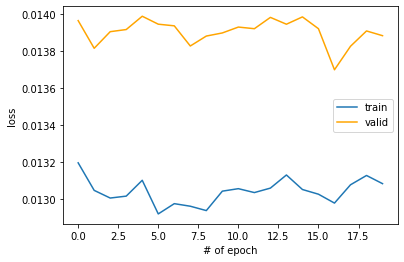

In [15]:
# Loss Plot
loss1, = plt.plot([i for i in range(len(train_loss))], torch.tensor(train_loss).mean(axis=1),
                    label='train loss')
loss2, = plt.plot([i for i in range(len(valid_loss))], valid_loss, color='orange',
                    label='valid loss')
plt.legend([loss1, loss2], ['train', 'valid'])
plt.xlabel('# of epoch')
plt.ylabel('loss')
plt.show()

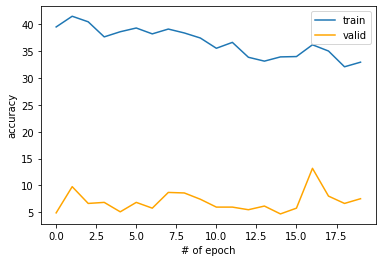

<Figure size 432x288 with 0 Axes>

In [16]:
# Accurary Plot
loss1, = plt.plot([i for i in range(len(train_acc))], torch.tensor(train_acc).mean(axis=1),
                    label='train acc')
loss2, = plt.plot([i for i in range(len(valid_acc))], valid_acc, color='orange',
                    label='valid acc')
plt.legend([loss1, loss2], ['train', 'valid'])
plt.xlabel('# of epoch')
plt.ylabel('accuracy')
plt.show()
plt.savefig('256_lr0.005_L1_noDrop.png')